In [6]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

## 1. Data

### 1.1 Extract data

In [9]:
df = pd.read_csv('ambient_temperature_system_failure.csv')

### 1.2 Understand data

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [19]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0   2013-07-04 00:00:00
1   2013-07-04 01:00:00
2   2013-07-04 02:00:00
3   2013-07-04 03:00:00
4   2013-07-04 04:00:00
5   2013-07-04 05:00:00
6   2013-07-04 06:00:00
7   2013-07-04 07:00:00
8   2013-07-04 08:00:00
9   2013-07-04 09:00:00
Name: timestamp, dtype: datetime64[ns]


In [12]:
# check the temperature mean
print(df['value'].mean())

71.24243270828815


<IPython.core.display.Javascript object>


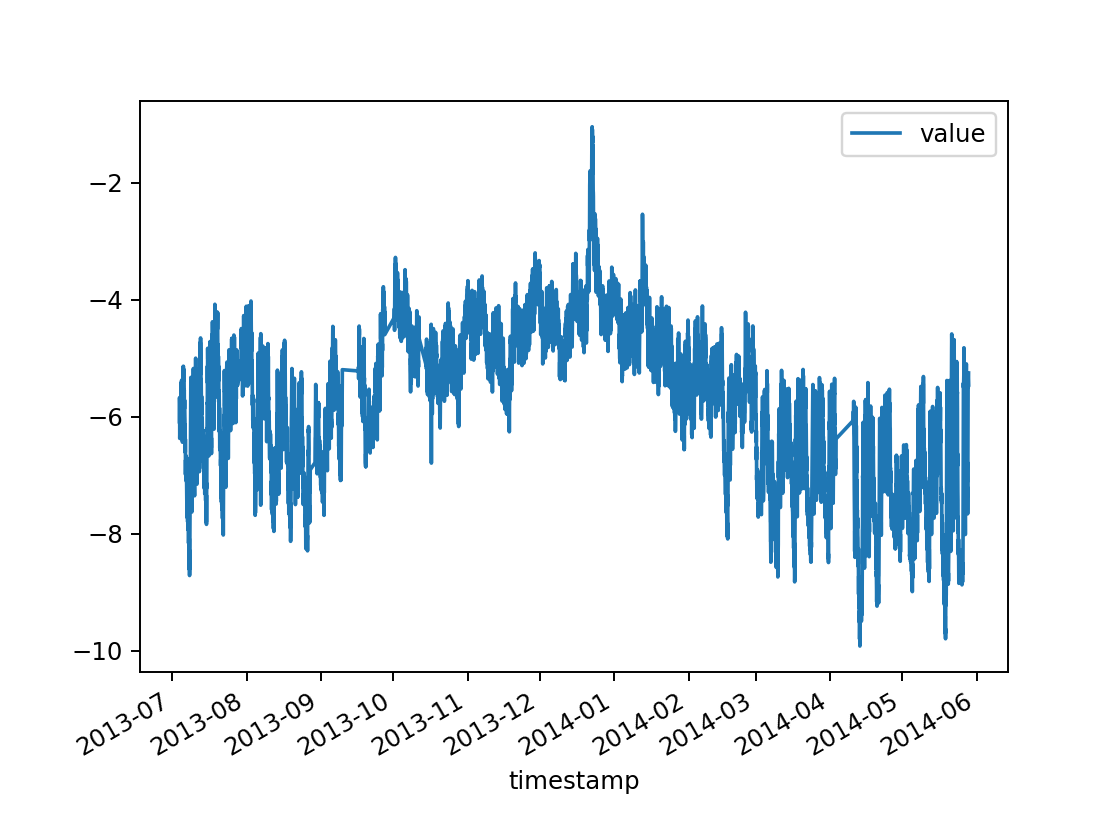

In [14]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

### 1.3 Feature engineering
Extracting some useful features

In [20]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [23]:
df['daylight'].head(20)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: daylight, dtype: int32

In [25]:
df['hours'].head(40)

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24     0
25     1
26     2
27     3
28     4
29     5
30     6
31     7
32     8
33     9
34    10
35    11
36    12
37    13
38    14
39    15
Name: hours, dtype: int64

In [26]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [38]:
df['WeekDay'].head(20)

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: WeekDay, dtype: int32

In [27]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [28]:
df['time_epoch']

0       13728960
1       13728996
2       13729032
3       13729068
4       13729104
          ...   
7262    14012748
7263    14012784
7264    14012820
7265    14012856
7266    14012892
Name: time_epoch, Length: 7267, dtype: int64

<IPython.core.display.Javascript object>


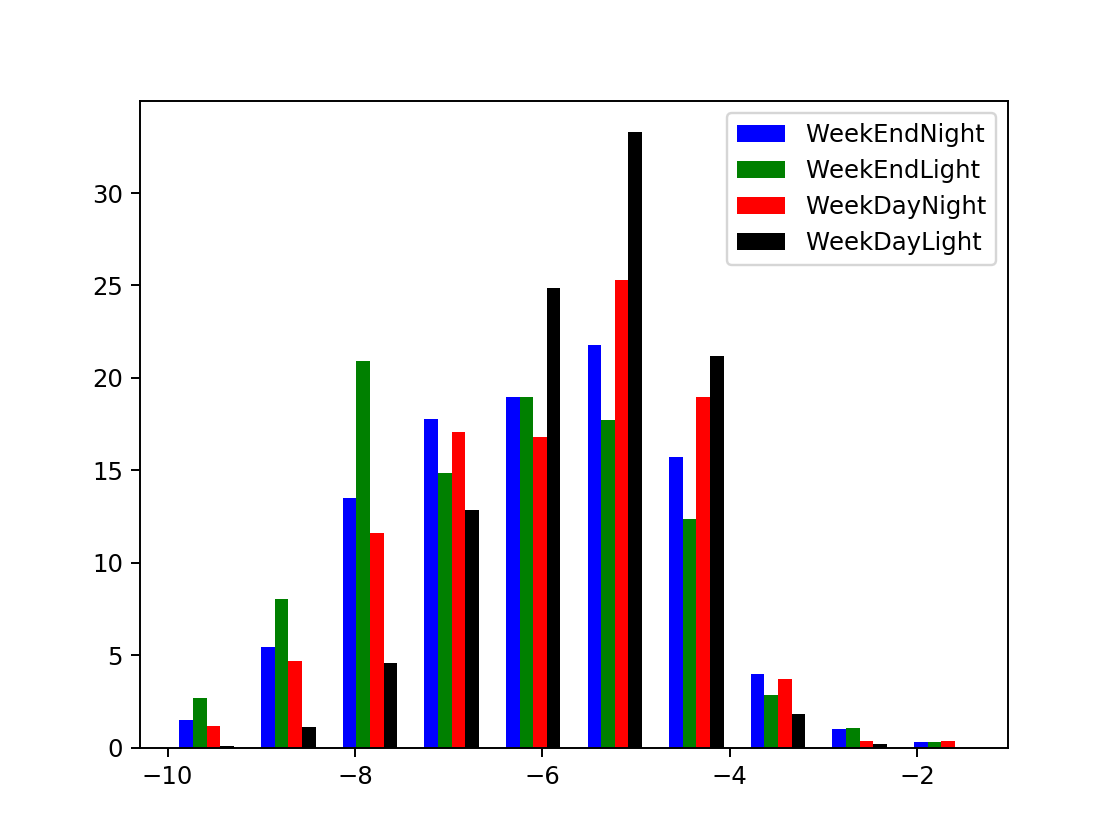

In [29]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [36]:
df['categories'] .head(50)

0     2
1     2
2     2
3     2
4     2
5     2
6     2
7     3
8     3
9     3
10    3
11    3
12    3
13    3
14    3
15    3
16    3
17    3
18    3
19    3
20    3
21    3
22    3
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    3
32    3
33    3
34    3
35    3
36    3
37    3
38    3
39    3
40    3
41    3
42    3
43    3
44    3
45    3
46    3
47    2
48    0
49    0
Name: categories, dtype: int32

In [42]:
df.head(150)

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,-6.086162,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,-5.672769,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,-5.778455,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,-6.370556,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,-6.270509,4,0,3,1,13729104,2
...,...,...,...,...,...,...,...,...
145,2013-07-10 01:00:00,-6.494701,1,0,2,1,13734180,2
146,2013-07-10 02:00:00,-6.749806,2,0,2,1,13734216,2
147,2013-07-10 03:00:00,-6.725879,3,0,2,1,13734252,2
148,2013-07-10 04:00:00,-6.996057,4,0,2,1,13734288,2
